In [1]:
import math
import scipy 
import datetime
import numpy as np
import pandas as pd

from scipy import stats
from scipy.stats import randint, loguniform

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


In [2]:
df = pd.read_excel('Online Retail.xlsx')
df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [3]:
df.shape

(541909, 8)

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


In [5]:
df.describe()

,Quantity,UnitPrice,CustomerID
count,541909.000000,541909.000000,406829.000000
mean,9.552250,4.611114,15287.690570
std,218.081158,96.759853,1713.600303
min,-80995.000000,-11062.060000,12346.000000
25%,1.000000,1.250000,13953.000000
50%,3.000000,2.080000,15152.000000
75%,10.000000,4.130000,16791.000000
max,80995.000000,38970.000000,18287.000000


In [6]:
df.describe(include='object').T

,count,unique,top,freq
InvoiceNo,541909,25900,573585,1114
StockCode,541909,4070,85123A,2313
Description,540455,4223,WHITE HANGING HEART T-LIGHT HOLDER,2369
Country,541909,38,United Kingdom,495478


In [7]:
df.isnull().sum()

InvoiceNo           0
StockCode           0
Description      1454
Quantity            0
InvoiceDate         0
UnitPrice           0
CustomerID     135080
Country             0
dtype: int64

In [8]:
# Creating RFM table Strategy

df_s = df.sample(10000, random_state=42)
df_s['InvoiceDate'] = df_s['InvoiceDate'].dt.date
df_s['TotalSum'] = df_s['Quantity'] * df_s['UnitPrice']
snapshot_date = max(df_s.InvoiceDate) + datetime.timedelta(days=1)

customers = df_s.groupby(['CustomerID']).agg({'InvoiceDate' : lambda x: (snapshot_date - x.max()).days, 
                                              'InvoiceNo': 'count','TotalSum': 'sum'})
customers.rename(columns = {'InvoiceDate':'Recency','InvoiceNo':'Frequency', 'TotalSum':'MonetaryValue'}, inplace=True)

display(customers.head())

,Recency,Frequency,MonetaryValue
CustomerID,,,
12347.0,3,5,81.60
12349.0,19,1,19.90
12353.0,205,1,39.80
12354.0,233,2,25.45
12356.0,326,1,50.00


In [9]:
customers.info()

<class 'pandas.core.frame.DataFrame'>
Float64Index: 2433 entries, 12347.0 to 18287.0
Data columns (total 3 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Recency        2433 non-null   int64  
 1   Frequency      2433 non-null   int64  
 2   MonetaryValue  2433 non-null   float64
dtypes: float64(1), int64(2)
memory usage: 76.0 KB


In [10]:
customers.describe()

,Recency,Frequency,MonetaryValue
count,2433.000000,2433.000000,2433.000000
mean,115.114673,3.076038,60.757185
std,105.746852,5.693838,205.094177
min,1.000000,1.000000,-1867.860000
25%,30.000000,1.000000,12.400000
50%,73.000000,2.000000,24.770000
75%,191.000000,3.000000,53.100000
max,374.000000,137.000000,4887.330000


## `EDA`

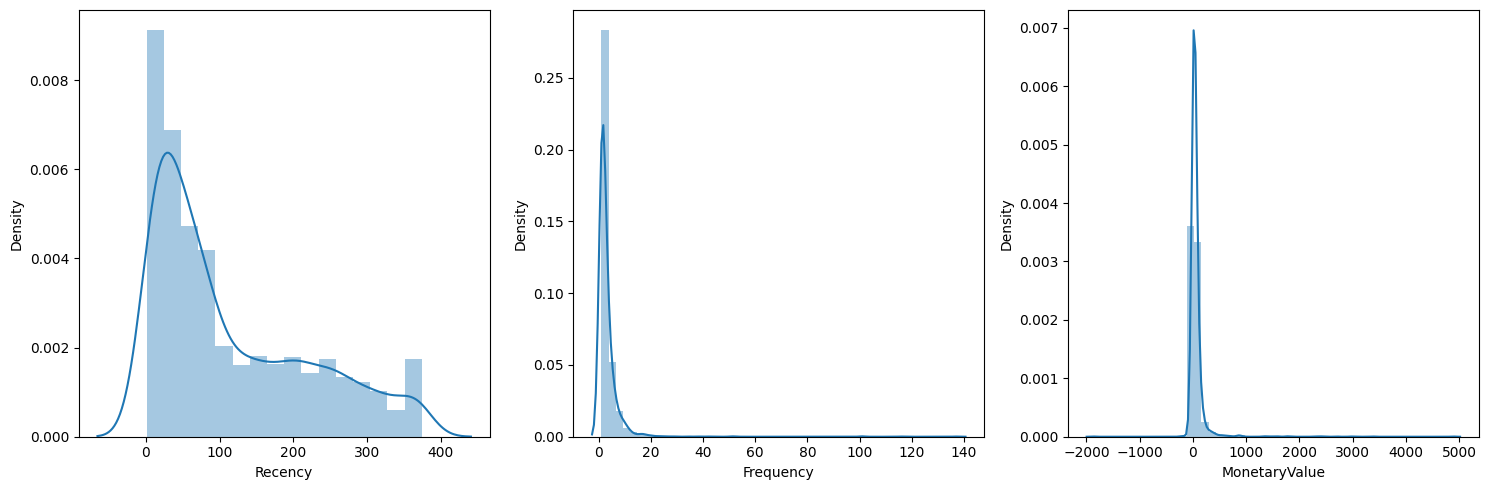

In [11]:
# RFM Distribution 

n = 3
nf = [i for i  in customers.columns]

plt.rcParams['figure.figsize'] =([15,5*math.ceil(len(nf)/n)])
for c in range(len(nf)):
    plt.subplot(math.ceil(len(nf)/n), n,c+1)
    sns.distplot(customers[nf[c]])

plt.tight_layout()
plt.show()

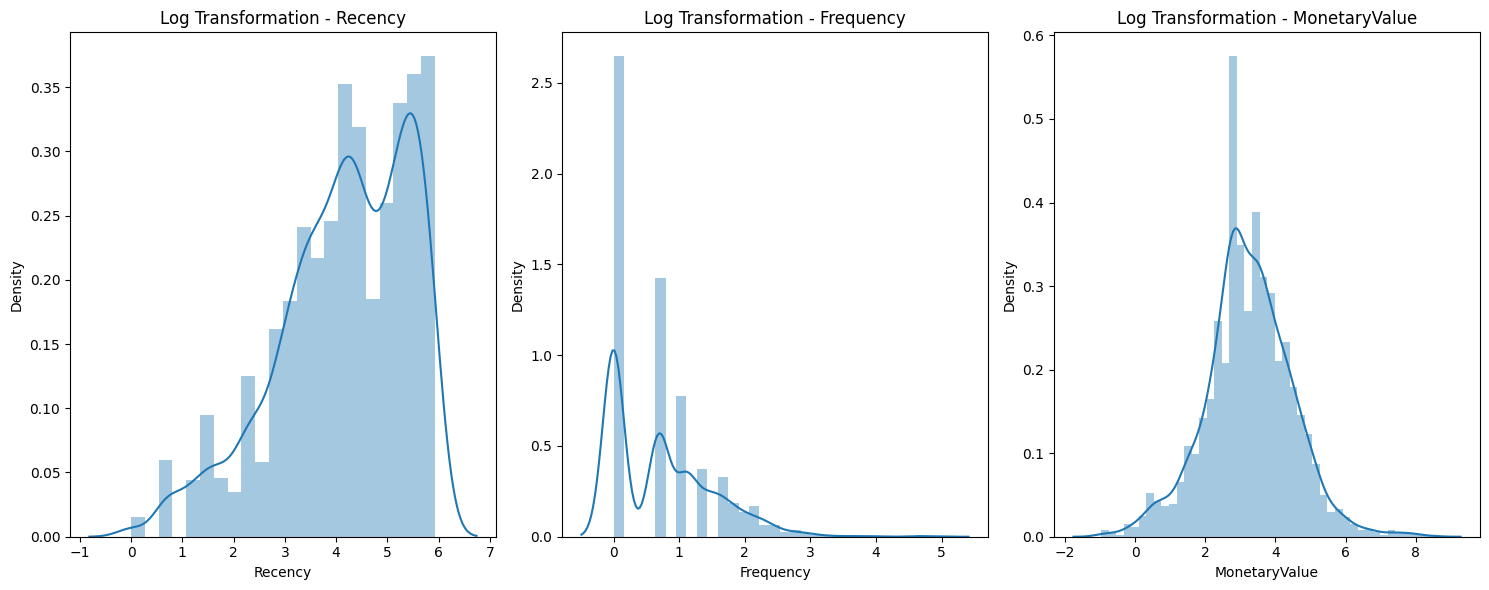

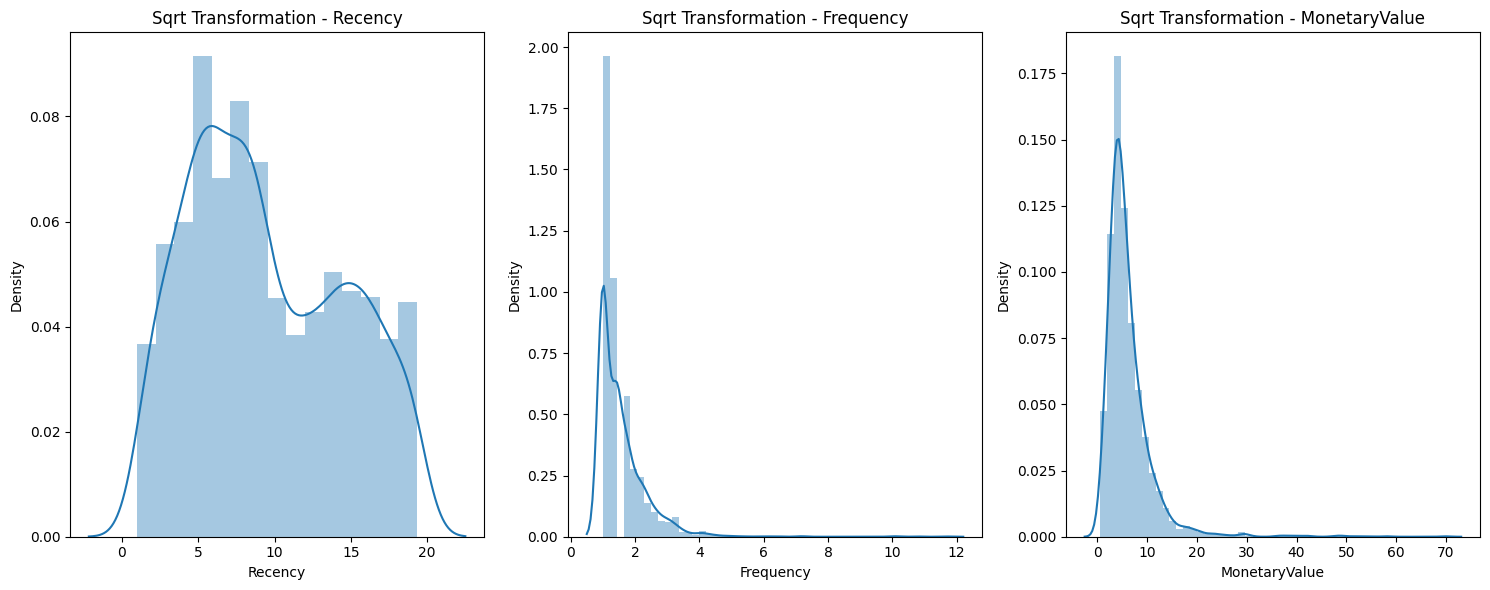

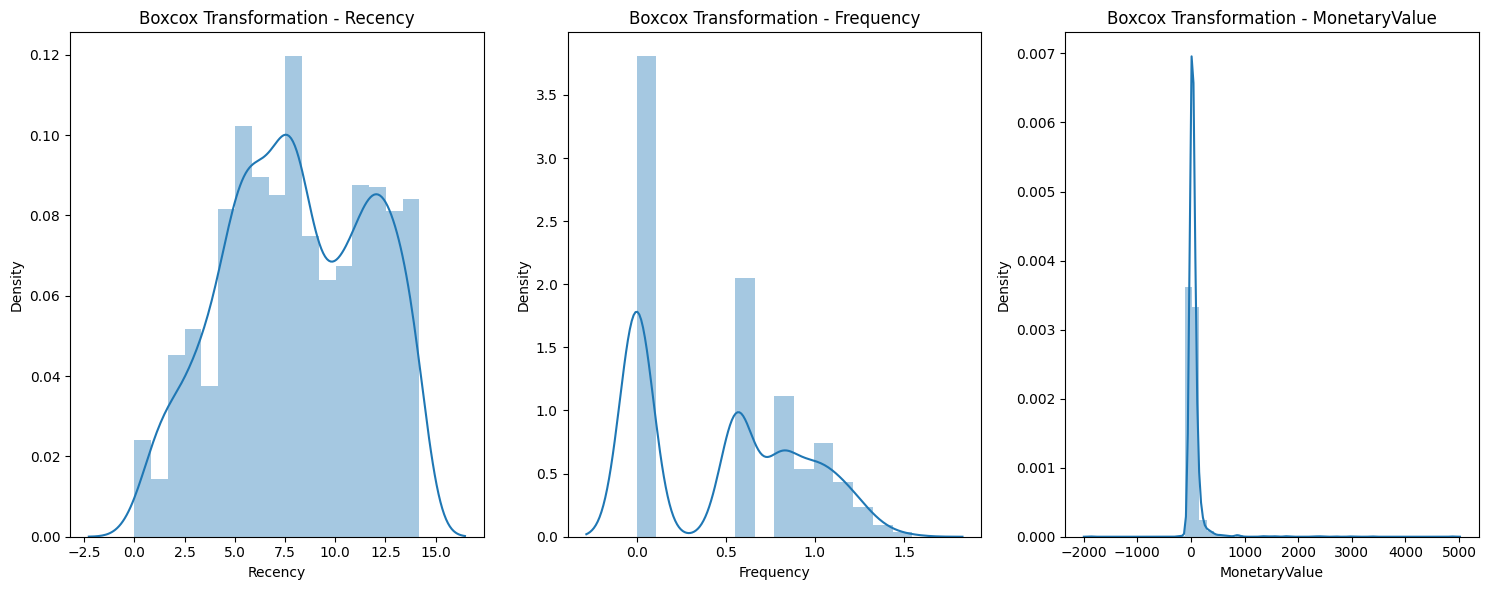

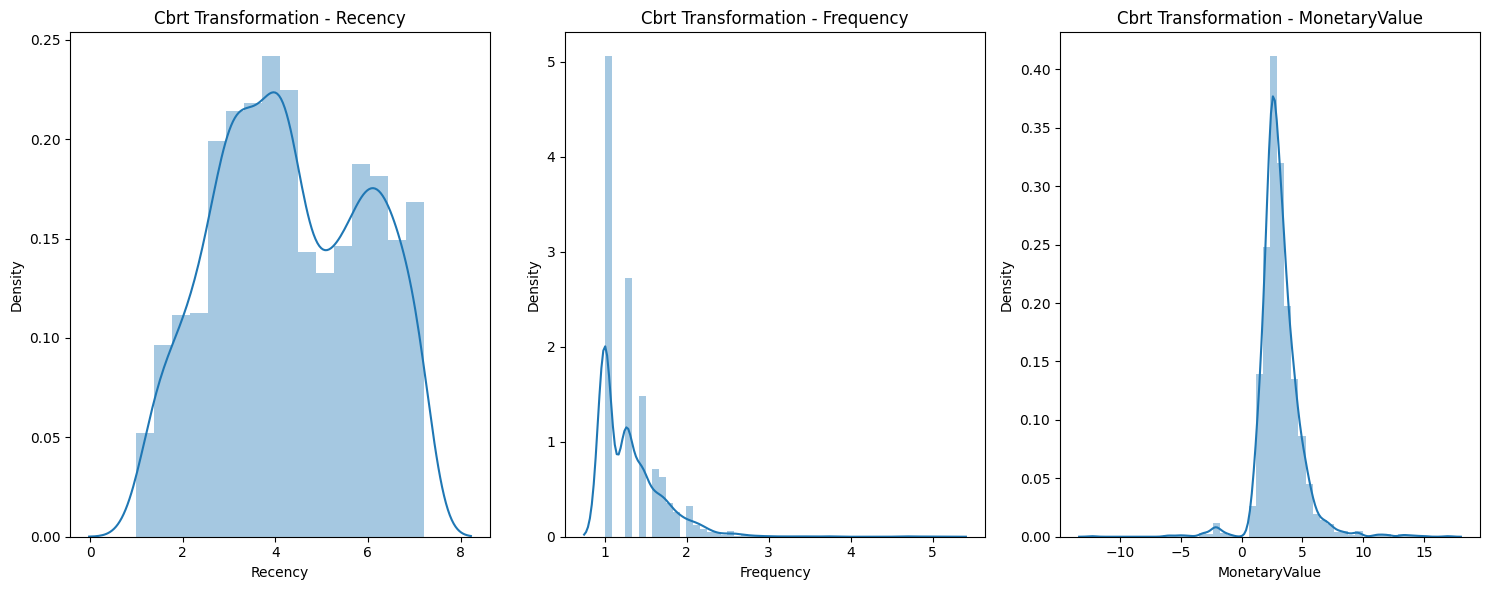

In [12]:
'''Testing Transform data'''

transformations = ['log', 'sqrt', 'boxcox', 'cbrt']

def apply_transformations(data):
    transformed_data = {}
    
    for transformation in transformations:
        transformed_data[transformation] = data.copy(deep=True)
        
        for col in data.columns:
            if transformation == 'log':
                transformed_data[transformation][col] = np.log(data[col])
            elif transformation == 'sqrt':
                transformed_data[transformation][col] = np.sqrt(data[col])
            elif transformation == 'cbrt':
                transformed_data[transformation][col] = np.cbrt(data[col])
            elif transformation == 'boxcox' and col != 'MonetaryValue':
                transformed_data[transformation][col] = stats.boxcox(data[col])[0]
    
    return transformed_data

transformed_customers = apply_transformations(customers)

for transformation in transformations:
    plt.rcParams['figure.figsize'] = ([15, 6*math.ceil(len(nf)/n)])
    
    for c in range(len(nf)):
        plt.subplot(math.ceil(len(nf)/n), n, c+1)
        sns.distplot(transformed_customers[transformation][nf[c]])
        plt.title('{} Transformation - {}'.format(transformation.capitalize(), nf[c]))
    
    plt.tight_layout()
    plt.show()


## `Data Preprocessing`

In [13]:
#Transform data using boxcox
customers_fix = pd.DataFrame()
customers_fix["Recency"] = stats.boxcox(customers['Recency'])[0]
customers_fix["Frequency"] = stats.boxcox(customers['Frequency'])[0]
customers_fix["MonetaryValue"] = pd.Series(np.cbrt(customers['MonetaryValue'])).values
customers_fix.head()

,Recency,Frequency,MonetaryValue
0,1.272970,1.021167,4.337406
1,4.437686,0.000000,2.709886
2,11.574022,0.000000,3.414242
3,12.098871,0.564199,2.941458
4,13.562344,0.000000,3.684031


## `Predictive modelling`

In [14]:
sc = StandardScaler()
sc.fit(customers_fix)
customers_norm = sc.transform(customers_fix)

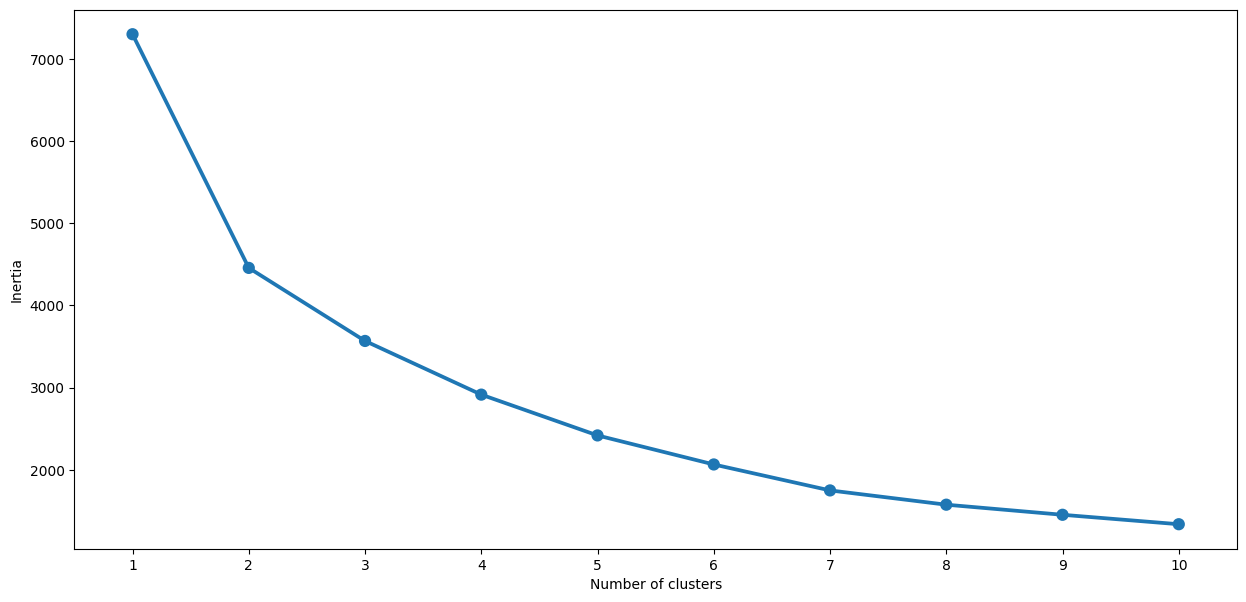

In [15]:
# using KMeans model
sse = []
for n in range(1,11):
    #model = KMeans(n_clusters=k, random_state=111, )
    model = (KMeans(n_clusters=n, init='k-means++', n_init=10, max_iter=300, tol=0.0001, random_state=111, algorithm='elkan'))
    model.fit(customers_norm)
    sse.append(model.inertia_)

plt.rcParams['figure.figsize']=(15,7)
sns.pointplot(x=list(range(1, 11)), y=sse)
plt.xlabel('Number of clusters'), plt.ylabel('Inertia')
plt.show()

In [24]:
model = (KMeans(n_clusters=3, init='k-means++', n_init=10, max_iter=300, random_state=111, algorithm='elkan'))
model.fit(customers_norm)

customers['Cluster'] = model.labels_
customers.groupby('Cluster').agg({
    'Recency': 'mean',
    'Frequency': 'mean',
    'MonetaryValue': ['mean', 'count']
}).round(2)

Recency Frequency MonetaryValue      
           mean      mean          mean count
Cluster                                      
0         45.59      1.48         19.59   774
1        233.26      1.53         23.21   881
2         50.50      6.42        144.23   778

In [25]:
df_norm = pd.DataFrame(customers_norm, columns=['Recency','Frequency','MonetaryValue'])
df_norm['ID'] = customers.index
df_norm['Cluster'] = model.labels_

In [26]:
# MELT DATA
df_nor_melt = pd.melt(df_norm.reset_index(),
                     id_vars=['ID','Cluster'],
                     value_vars=['Recency','Frequency','MonetaryValue'],
                     var_name ='Attribute',
                     value_name='Value')
df_nor_melt.head()

,ID,Cluster,Attribute,Value
0,12347.0,2,Recency,-1.902050
1,12349.0,0,Recency,-1.020610
2,12353.0,1,Recency,0.967009
3,12354.0,1,Recency,1.113190
4,12356.0,1,Recency,1.520798


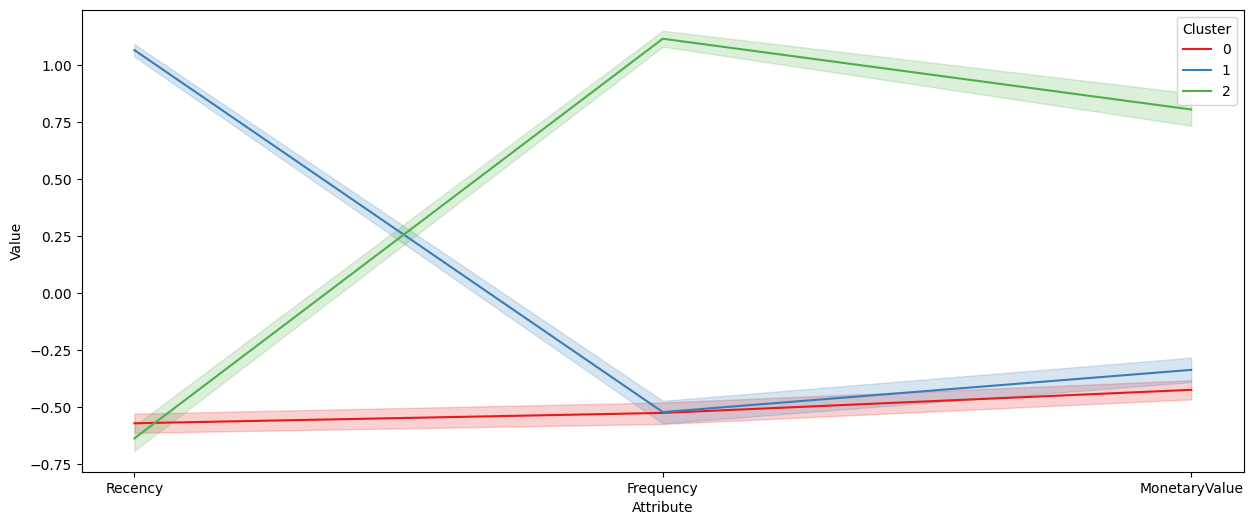

In [29]:
plt.rcParams['figure.figsize'] =(15,6)
sns.lineplot(x='Attribute',y='Value', hue='Cluster', palette='Set1', data=df_nor_melt)
plt.show()